# Welcome to Machine Learning -- An Interdisciplinary Introduction

## Classification

A classification task is to assign a specific class to a given sample.
One of the most simple classification algorithms is the k-nearest-neighbor classifier.
Given a training set of samples 
$$X = \{(\vec x_n, t_n) \mid 0\leq n<N \}$$
we can simply store all the samples and their labels.
For a given test sample $\vec x$, we iterate through the training set and compute the labels of the $K$ neaeast neighbors.
That is, we compute the distances to all training set samples:
$$D = \{\|\vec x_n- \vec x\|^2 \mid 0\leq n<N\}$$
and select those samples with the minimum distances.
Then, we assign the class to the sample that appears most often in the nearest neighbors.

## Dataset

We make use of the [Iris Flower dataset](https://archive.ics.uci.edu/ml/datasets/iris).
The dataset contains three different types of iris flowers, where the length and the width of sepal and pedal of the flowers are measured.
Let us first download the original data:

In [1]:
import os
import urllib.request

# load the dataset
dataset_file = "iris.data"
if not os.path.exists(dataset_file):
  urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", dataset_file)
  print ("Downloaded datafile", dataset_file)

Now, let us read the data from file. 
Note that the whole dataset is contained in one file.
The labels are given as text, which we translate into a 0-based index, which our code can handle better:

In [2]:
import csv
import torch

# read the data
with open(dataset_file, 'r') as f:
  reader = csv.reader(f, delimiter=",")
  class_names = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
  # read all data
  X, T = [], []
  for splits in reader:
    if splits:
      X.append([float(x) for x in splits[:4]])
      T.append(class_names.index(splits[4]))

# We turn the data into torch tensors for easier handling
X = torch.tensor(X)
T = torch.tensor(T)

We want to split off training and testing data.
Ideally, we would also define a validation set, but for the purpose of this small exercise, we abstain from doing so.

Let us first have a look into the structure of the labels:

In [3]:
# we print the whole list of labels
print(T)
# count how often each of the three labels exist in the dataset
for t in range(3):
  print(t, torch.sum(T==t))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])
0 tensor(50)
1 tensor(50)
2 tensor(50)


OK, they are sorted, and we have 50 of each label.
Let's split 25 samples of each class for training, and the other 25 for testing.

In [4]:
# we define the number of training samples per class that we use
split = 25

# split them into training and test set
train_indexes = list(range(split)) + list(range(50,50+split)) + list(range(100,100+split))
test_indexes = list(range(split,50)) + list(range(50+split,100)) + list(range(100+split,150))

# Assign the training and test data and labels
train_data = X[train_indexes]
train_labels = T[train_indexes]
test_data = X[test_indexes]
test_labels = T[test_indexes]

### Data visualization
Let's visualize our data, as far as we can.
We plot each two dimensions of our data, with colors corresponding to the original classes, which shows that these samples cluster.

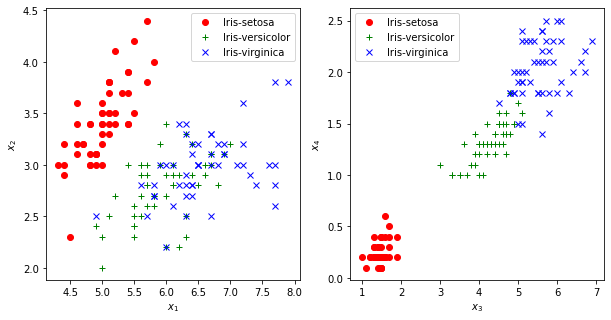

In [5]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,5))
for i in range(2):
  # we create two horizontally aligned subplots
  pyplot.subplot(1,2,i+1)
  # select dimensions 1 and 2 or 3 and 4 for visualization (remember 0-based indexing)
  d1, d2 = 2*i,2*i+1
  # plot all samples of each class in a separate color
  pyplot.plot(X[T==0,d1], X[T==0,d2], "ro", label=class_names[0])
  pyplot.plot(X[T==1,d1], X[T==1,d2], "g+", label=class_names[1])
  pyplot.plot(X[T==2,d1], X[T==2,d2], "bx", label=class_names[2])
  # make the plot more beautiful by adding 
  pyplot.xlabel(f"$x_{d1+1}$")
  pyplot.ylabel(f"$x_{d2+1}$")
  pyplot.legend()

## Task 1: K Nearest Neighbor Function

Write a function that computes the $K$ nearest neighbors from the training set.
This function takes the entire training set `X` and its according labels `T`. 
Additionally, it takes one test `sample` that should be classified, and the number of nearest neighbors `K` to consider.

In [6]:
def kNN(X, T, sample, K=5):
  """Predicts the class for the given sample using the k-nearest-neighbor algorithm.
  For each training sample (x,t), it computes the Euclidean distance to the test sample.
  The classes of the K nearest samples are considered, and the test sample is assigned to the majority class.

  Parameters:
  X: torch.tensor(float) in shape (N,D): The training set samples where N is the number of samples and D is the sample dimensionality.
  T: torch.tensor(int) in shape (N): The training set labels representing the target classes.
  sample: torch.tensor(float) in shape (D): The current test sample
  K: int: The number of nearest neighbors to consider

  Returns:
  int: the predcicted class index for the test sample
  """
  # compute distances
  distances = torch.sum((X - sample)**2, dim=1)

  # sort the distances and get the indexes of the K nearest samples
  indexes = torch.argsort(distances)[:K]

  # get the labels from those samples
  labels = T[indexes]

  # count the labels, i.e., how often was a class predicted
  counts = torch.tensor([torch.sum(labels == t) for t in range(3)])

  # return the label of the maximum count
  return torch.argmax(counts)

## Task 2: Correct Classification

Select a value of $K$ of your choice.
Classify all test set samples and count how often the correct class was predicted.
Which value of $K$ works best in this case?

In [7]:
# iterate through all of our test samples and compute its class prediction
predictions = []
for sample in test_data:
  # compute class prediction for current test sample
  prediction = kNN(train_data, train_labels, sample, K=1)
  # store it in our list
  predictions.append(prediction)
# turn them imto torch tensors for further processing
predictions = torch.tensor(predictions)

# compute the total number of correct classifications, i.e., where the prediction and the test label are equal
correct = torch.sum(predictions == test_labels)
# obtain the total number of test samples
total = len(test_labels)

Seeing the total number of correctly classified samples might not be sufficient.
It is better if we could also see, which classes are confused with which other classes.
For this purpose, we can plot a confusion matrix.
The easiest way of plotting this is by using the `sklearn.metrics.ConfusionMatrixDisplay.from_predictions` function.

## Task 3: Confusion Matrix Plot

Plot a confusion matrix between the correct labels and the predicted outputs.

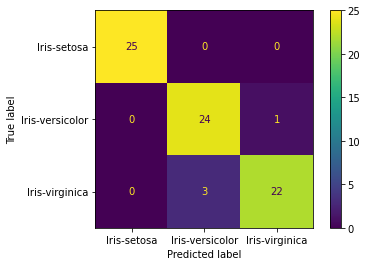

In [8]:
import sklearn.metrics
_= sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions, display_labels=class_names)

## Task 4: Discuss Issues of k-Nearest Neighbors

Problems of the k-nearest neighbor approach include the following:

* Selection of $K$: how can we find out how many neighbors we need?
* Tie-breaker: what happens when neighbor counts from two classes are identical and maximal?
* Training data selection: which training samples should we keep, and which samples might be superfluous?

Discuss possible solutions to these issues.
